In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import yfinance as yf
sys.path.append(os.path.abspath("../src"))
from data_cleaner import DataCleanerConfig, DataCleaner, preprocess_data

# Para ir tocando data_cleaner sin tener que reiniciar el kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Configuración para datos a 5m
cfg_5m = DataCleanerConfig(
    source="alpaca",
    symbol="QQQ",
    interval="5m",
    start_date="2022-01-01",
    end_date="2025-10-30",
   
)

cleaner = DataCleaner(cfg_5m)
df_raw = cleaner.cargar_datos()
df = preprocess_data(df_raw)

df

,symbol,datetime,open,high,low,close,volume,trade_count,vwap,volume_norm,return,log_return_raw,log_return_close,log_ret_oc,log_ret_hl,log_ret_ch,log_ret_cl
0,QQQ,2022-01-03 09:05:00+00:00,399.390,399.4000,399.250,399.40,7602.0,93.0,399.340687,-0.591507,0.000000,5.989963,0.000000,0.000025,0.000376,0.000000,0.000376
1,QQQ,2022-01-03 09:10:00+00:00,399.390,399.5300,399.380,399.53,7260.0,53.0,399.424946,-0.592268,0.000325,5.990289,0.000325,0.000350,0.000376,0.000000,0.000376
2,QQQ,2022-01-03 09:15:00+00:00,399.540,399.5600,399.340,399.35,6878.0,112.0,399.470116,-0.593119,-0.000451,5.989838,-0.000451,-0.000476,0.000551,-0.000526,0.000025
3,QQQ,2022-01-03 09:20:00+00:00,399.330,399.4900,399.300,399.49,7998.0,48.0,399.398335,-0.590625,0.000351,5.990189,0.000351,0.000401,0.000476,0.000000,0.000476
4,QQQ,2022-01-03 09:25:00+00:00,399.480,399.4800,399.400,399.40,1444.0,30.0,399.447894,-0.605217,-0.000225,5.989963,-0.000225,-0.000200,0.000200,-0.000200,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181169,QQQ,2025-10-29 23:35:00+00:00,633.910,633.9100,633.290,633.40,25018.0,253.0,633.474237,-0.552732,-0.000978,6.451102,-0.000978,-0.000805,0.000979,-0.000805,0.000174
181170,QQQ,2025-10-29 23:40:00+00:00,633.430,633.4700,633.050,633.47,13426.0,139.0,633.327080,-0.578540,0.000111,6.451213,0.000111,0.000063,0.000663,0.000000,0.000663
181171,QQQ,2025-10-29 23:45:00+00:00,633.591,634.1800,633.591,634.18,7615.0,124.0,634.025177,-0.591478,0.001121,6.452333,0.001120,0.000929,0.000929,0.000000,0.000929
181172,QQQ,2025-10-29 23:50:00+00:00,634.190,634.8500,634.190,634.81,12905.0,177.0,634.664857,-0.579700,0.000993,6.453326,0.000993,0.000977,0.001040,-0.000063,0.000977


In [3]:
df.columns

Index(['symbol', 'datetime', 'open', 'high', 'low', 'close', 'volume',
       'trade_count', 'vwap', 'volume_norm', 'return', 'log_return_raw',
       'log_return_close', 'log_ret_oc', 'log_ret_hl', 'log_ret_ch',
       'log_ret_cl'],
      dtype='object')

In [4]:
FEATURE_COLUMNS = [
    "open", "high", "low", "close",
    "volume", "trade_count", "vwap",
    "volume_norm",
    "return",
    "log_return_close",
    "log_ret_oc",
    "log_ret_hl",
    "log_ret_ch",
    "log_ret_cl"
]

HORIZON = 24  # 24 velas de 5m = 2 horas

df = df.copy()
df["target_2h"] = np.log(df["close"].shift(-HORIZON) / df["close"])


#Quitamos filas sin target
df = df.dropna().reset_index(drop=True)

In [5]:
HORIZON = 24
df["close_future"] = df["close"].shift(-HORIZON)

# dirección:
df["direction_2h"] = (df["close_future"] > df["close"]).astype(int)

df = df.dropna(subset=["direction_2h"]).reset_index(drop=True)


In [6]:
last_ts = df["datetime"].max()
test_start = last_ts - pd.Timedelta(days=7)

df_train = df[df["datetime"] < test_start].reset_index(drop=True)
df_test  = df[df["datetime"] >= test_start].reset_index(drop=True)

df_train.shape, df_test.shape

((180191, 20), (959, 20))

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_raw = df_train[FEATURE_COLUMNS].values
X_test_raw  = df_test[FEATURE_COLUMNS].values

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)

# Reconstruimos dataframes escalados
df_train_scaled = pd.DataFrame(X_train_scaled, columns=FEATURE_COLUMNS)
df_train_scaled["datetime"] = df_train["datetime"].values
df_train_scaled["direction_2h"] = df_train["direction_2h"].values

df_test_scaled = pd.DataFrame(X_test_scaled, columns=FEATURE_COLUMNS)
df_test_scaled["datetime"] = df_test["datetime"].values
df_test_scaled["direction_2h"] = df_test["direction_2h"].values

df_train_scaled["target_2h"] = df_train["target_2h"].values
df_test_scaled["target_2h"] = df_test["target_2h"].values



In [8]:
import torch
from torch.utils.data import Dataset, DataLoader

class SlidingWindowDataset(Dataset):
    def __init__(self, df, feature_cols, target_col="target_2h", seq_len=64):
        """
        df: dataframe escalado con columnas features + datetime + target_2h
        """
        self.seq_len = seq_len
        self.feature_cols = feature_cols
        
        # Convertimos a tensores para PyTorch
        self.features = torch.tensor(df[feature_cols].values, dtype=torch.float32)
        self.targets = torch.tensor(df[target_col].values, dtype=torch.float32)
        
        # Guardamos timestamps en formato string (por simplicidad)
        self.timestamps = df["datetime"].astype(str).values

    def __len__(self):
        return len(self.features) - self.seq_len

    def __getitem__(self, idx):
        # Secuencia de tamaño seq_len
        x = self.features[idx : idx + self.seq_len]

        # Target para horizon = seq_len + 24 (pero ya está hecho en target_2h)
        y = self.targets[idx + self.seq_len]

        # Timestamp del momento donde hacemos la predicción
        ts = self.timestamps[idx + self.seq_len]

        return x, y, ts


In [9]:
SEQ_LEN = 64  # ventana de observación (64 velas)

train_dataset = SlidingWindowDataset(
    df_train_scaled, 
    feature_cols=FEATURE_COLUMNS,
    target_col="target_2h",
    seq_len=SEQ_LEN
)

test_dataset = SlidingWindowDataset(
    df_test_scaled, 
    feature_cols=FEATURE_COLUMNS,
    target_col="target_2h",
    seq_len=SEQ_LEN
)

len(train_dataset), len(test_dataset)


(180127, 895)

In [10]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [11]:
# Ver un batch
xb, yb, tsb = next(iter(train_loader))

print("Batch X:", xb.shape)   # (batch, seq_len, num_features)
print("Batch y:", yb.shape)   # (batch,)
print("Timestamp example:", tsb[0])


Batch X: torch.Size([64, 64, 14])
Batch y: torch.Size([64])
Timestamp example: 2023-08-29 09:35:00


# Ahora la LSTM

In [12]:
import torch.nn as nn

class LSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.2):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        # LayerNorm ayuda MUCHO a la estabilidad del entrenamiento
        self.norm = nn.LayerNorm(hidden_dim)

        # Capa final para sacar la predicción del log-return
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        last_hidden = out[:, -1, :]      # último estado
        last_hidden = self.norm(last_hidden)
        out = self.fc(last_hidden)
        return out.squeeze(-1)


In [13]:
input_dim = len(FEATURE_COLUMNS)

model = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2
)

model


LSTMRegressor(
  (lstm): LSTM(14, 64, num_layers=2, batch_first=True, dropout=0.2)
  (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

## Configuramos el entrenamiento

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Pérdida: Huber (SmoothL1) suele ir mejor que MSE en finanzas
criterion = nn.SmoothL1Loss()

# Optimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [15]:
def train_lstm(model, train_loader, test_loader, num_epochs=10):
    model.train()
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(1, num_epochs + 1):
        # ---- TRAIN ----
        model.train()
        train_losses = []

        for xb, yb, _ in train_loader:      # ignoramos timestamp
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()

            # prevención explosión de gradientes
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            train_losses.append(loss.item())

        # ---- VALID ----
        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb, _ in test_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        epoch_train_loss = sum(train_losses) / len(train_losses)
        epoch_val_loss = sum(val_losses) / len(val_losses)

        history["train_loss"].append(epoch_train_loss)
        history["val_loss"].append(epoch_val_loss)

        print(f"Epoch {epoch:02d} | Train loss: {epoch_train_loss:.6f} | Val loss: {epoch_val_loss:.6f}")

    return history


In [16]:
history = train_lstm(model, train_loader, test_loader, num_epochs=10)


Epoch 01 | Train loss: 0.000222 | Val loss: 0.000007
Epoch 02 | Train loss: 0.000021 | Val loss: 0.000020
Epoch 03 | Train loss: 0.000019 | Val loss: 0.000009
Epoch 04 | Train loss: 0.000018 | Val loss: 0.000044
Epoch 05 | Train loss: 0.000017 | Val loss: 0.000021
Epoch 06 | Train loss: 0.000017 | Val loss: 0.000011
Epoch 07 | Train loss: 0.000016 | Val loss: 0.000008
Epoch 08 | Train loss: 0.000016 | Val loss: 0.000004
Epoch 09 | Train loss: 0.000015 | Val loss: 0.000004
Epoch 10 | Train loss: 0.000015 | Val loss: 0.000003


In [17]:
import numpy as np
import torch

# PREDICCIONES DEL MODELO
model.eval()

y_true_list = []
y_pred_list = []
ts_list = []
close_list = []

with torch.no_grad():
    for xb, yb, tsb in test_loader:
        xb = xb.to(device)
        preds = model(xb)

        y_true_list.append(yb.cpu().numpy())
        y_pred_list.append(preds.cpu().numpy())
        ts_list.extend(list(tsb))

y_true = np.concatenate(y_true_list)
y_pred = np.concatenate(y_pred_list).ravel()
ts_arr = np.array(ts_list)

print(y_true.shape, y_pred.shape, ts_arr.shape)



(895,) (895,) (895,)


In [18]:
close_series = df_test["close"].values

close_aligned = []
idx = 0
for xb, yb, tsb in test_loader:
    batch_size = len(yb)
    close_aligned.append(close_series[idx : idx + batch_size])
    idx += batch_size

close_arr = np.concatenate(close_aligned)

In [19]:
results = pd.DataFrame({
    "datetime": pd.to_datetime(ts_arr),
    "target_2h": y_true,
    "pred_2h": y_pred,
    "close": close_arr      
})


In [20]:
# === 3. Señales, PnL, equity y capital ===

# Usamos cuantiles de las predicciones para NO tener 100% cortas o 100% largas
q_low  = results["pred_2h"].quantile(0.25)
q_high = results["pred_2h"].quantile(0.75)

results["signal"] = 0
results.loc[results["pred_2h"] <= q_low,  "signal"] = -1   # short
results.loc[results["pred_2h"] >= q_high, "signal"] = 1    # long

# PnL en log-return: señal * retorno real a 2h
results["pnl"] = results["signal"] * results["target_2h"]

# Equity en base 1
results["equity"] = np.exp(results["pnl"].cumsum())

# Capital real reinvirtiendo SIEMPRE TODO
INITIAL_CAPITAL = 100_000.0
results["capital"] = INITIAL_CAPITAL * results["equity"]

results[["datetime", "pred_2h", "target_2h", "signal", "pnl", "equity", "capital"]].head()



,datetime,pred_2h,target_2h,signal,pnl,equity,capital
0,2025-10-23 11:15:00,0.001776,-0.000629,0,-0.0,1.0,100000.0
1,2025-10-23 11:20:00,0.001848,-0.000447,0,-0.0,1.0,100000.0
2,2025-10-23 11:25:00,0.001832,-0.000083,0,-0.0,1.0,100000.0
3,2025-10-23 11:30:00,0.001812,0.000876,0,0.0,1.0,100000.0
4,2025-10-23 11:35:00,0.001777,0.002312,0,0.0,1.0,100000.0


In [21]:
# Simulación de capital real partiendo de 100k,
# reinvirtiendo siempre TODO el capital

INITIAL_CAPITAL = 100_000.0  # 100k

# capital_t = capital_0 * equity_t
results["capital"] = INITIAL_CAPITAL * results["equity"]

print(f"Capital inicial: {INITIAL_CAPITAL:,.0f} USD")
print(f"Capital final:   {results['capital'].iloc[-1]:,.0f} USD")
print(f"Rentabilidad:    {results['capital'].iloc[-1] / INITIAL_CAPITAL - 1:.2%}")

results.tail()


Capital inicial: 100,000 USD
Capital final:   73,475 USD
Rentabilidad:    -26.53%


,datetime,target_2h,pred_2h,close,signal,pnl,equity,capital
890,2025-10-29 21:35:00,-0.000552,0.001890,634.5802,1,-0.000552,0.734819,73481.856331
891,2025-10-29 21:40:00,-0.001199,0.001875,635.0901,0,-0.000000,0.734819,73481.856331
892,2025-10-29 21:45:00,-0.000095,0.001919,635.1500,1,-0.000095,0.734749,73474.904843
893,2025-10-29 21:50:00,0.000331,0.001857,635.0600,0,0.000000,0.734749,73474.904843
894,2025-10-29 21:55:00,0.003030,0.001859,635.0800,0,0.000000,0.734749,73474.904843


=== Métricas en términos de equity (base 1) ===
Equity inicial: 1.000
Equity final:   0.735
Retorno total:  -26.53%

=== Métricas en términos de capital (100k iniciales) ===
Capital inicial: 100,000 USD
Capital final:   73,475 USD
Rentabilidad:    -26.53%

Nº señales (trades): 448
% señales largas:    50.0%
% señales cortas:    50.0%


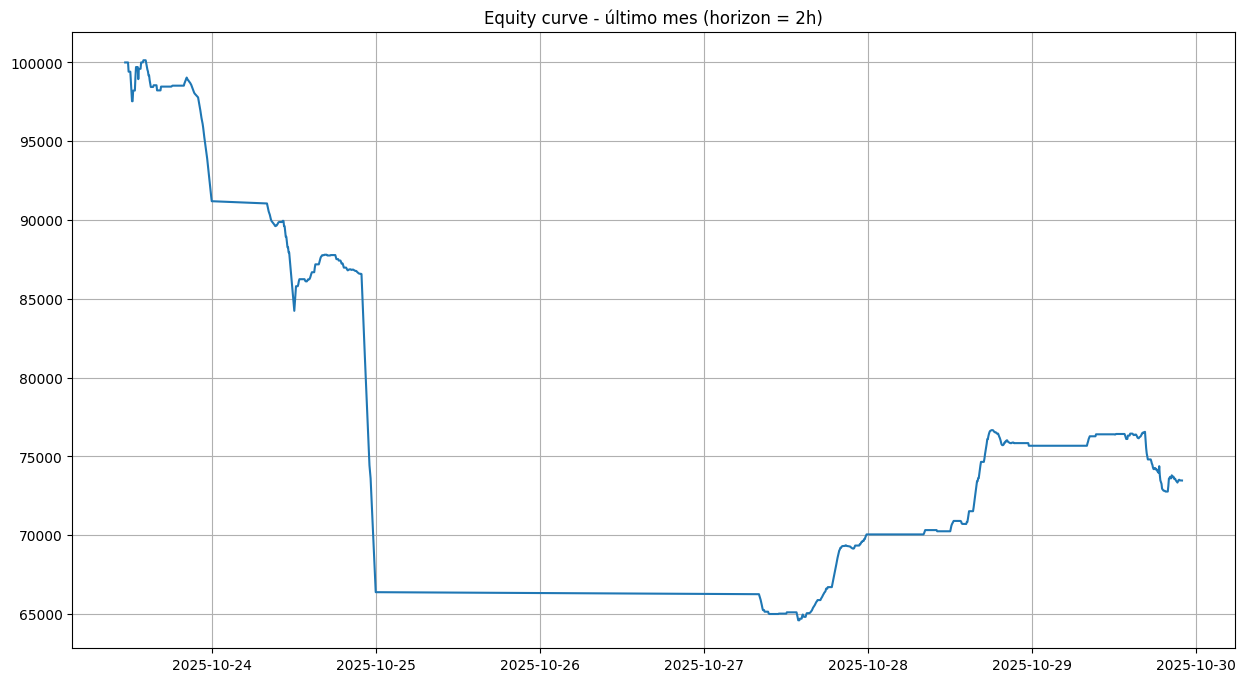

In [22]:
# === 4. Métricas del backtest y curva de capital ===

equity_final = results["equity"].iloc[-1]
ret_total = equity_final - 1

# Solo contamos trades cuando hay señal ≠ 0
n_trades = (results["signal"] != 0).sum()

# Número de largas y cortas reales
n_largos = (results["signal"] > 0).sum()
n_cortos = (results["signal"] < 0).sum()

# Porcentajes correctos
pct_largos = n_largos / n_trades if n_trades > 0 else 0
pct_cortos = n_cortos / n_trades if n_trades > 0 else 0

capital_final = results["capital"].iloc[-1]

print("=== Métricas en términos de equity (base 1) ===")
print(f"Equity inicial: 1.000")
print(f"Equity final:   {equity_final:.3f}")
print(f"Retorno total:  {ret_total:.2%}")
print()
print("=== Métricas en términos de capital (100k iniciales) ===")
print(f"Capital inicial: 100,000 USD")
print(f"Capital final:   {capital_final:,.0f} USD")
print(f"Rentabilidad:    {capital_final / 100000 - 1:.2%}")
print()
print(f"Nº señales (trades): {n_trades}")
print(f"% señales largas:    {pct_largos:.1%}")
print(f"% señales cortas:    {pct_cortos:.1%}")

plt.figure(figsize=(15,8))
plt.plot(results["datetime"], results["capital"])
plt.title("Equity curve - último mes (horizon = 2h)")
plt.grid(True)
plt.show()
